In [15]:
import pandas as pd
import numpy as np
import shap
import argparse

import seaborn

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def read_any(file, header):
    if file.endswith('.csv') or file.endswith('.tsv'):
        if header:
            df = pd.read_csv(file, header=0)
        else:
            df = pd.read_csv(file)
    elif file.endswith('.json'):
        df = pd.read_json(file)
    elif file.endswith('.xml'):
        df = pd.read_xml(file)
    elif file.endswith('.xls') or file.endswith('.xlsx'):
        df = pd.read_excel(file)
    elif file.endswith('.hdf'):
        df = pd.read_hdf(file)
    elif file.endswith('.sql'):
        df = pd.read_sql(file)
    else:
        raise ValueError(f'Unsupported filetype: {file}')
    return df

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('data', help='path to the file with dataset')
parser.add_argument('target', help='index of the target column', type=int)
parser.add_argument('--header', action='store_true')

args = parser.parse_args(['diabetes_binary_health_indicators_BRFSS2021.csv', '0', '--header'])

In [4]:
data = read_any(args.data, args.header)
target_idx = args.target
target = data.iloc[:, target_idx]
data = data.drop(columns=data.columns[target_idx])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target)

In [5]:
data.shape, target.shape

((236378, 21), (236378,))

In [6]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

In [7]:
model_params = {
    'eval_metric': 'F1',
    'custom_metric': ['Accuracy', 'Precision', 'Recall'],
}

grid_params = {
    'iterations': np.linspace(1000, 3000, 2, dtype=int),
    'learning_rate': np.logspace(-2, 0, 2),
    'l2_leaf_reg': np.logspace(-2, 1, 2)
}

model = CatBoostClassifier(**model_params, logging_level='Silent')
params, cv_results = model.grid_search(grid_params, train_pool, plot=True, verbose=False)

In [8]:
params = {'iterations': 3000, 'learning_rate': 0.5, 'l2_leaf_reg': 1}

In [9]:
params = {**model_params, **params, 'auto_class_weights': 'Balanced'}

final_model = CatBoostClassifier(**params)
final_model.fit(train_pool, eval_set=test_pool, silent=True)

---

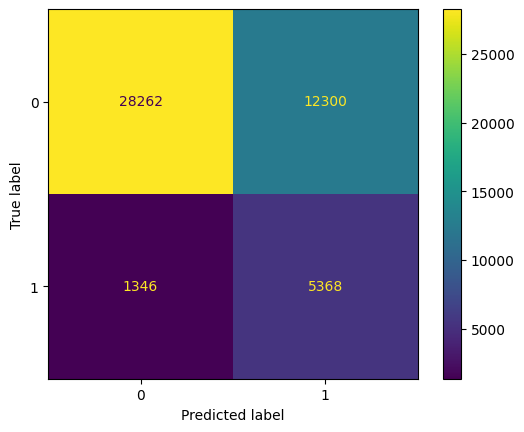

In [14]:
confusion = confusion_matrix(y_test, final_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()

---

In [27]:
def calc_metric_folded(clf, X_test, y_test, metric, n_folds=5):
    scores = []
    for X_test_fold, y_test_fold in zip(np.array_split(X_test, folds_num), np.array_split(y_test, folds_num)):
        scores.append(metric(y_test_fold, clf.predict(X_test_fold)))
    return np.array(scores)

In [29]:
calc_metric_folded(final_model, X_test, y_test, f1_score).std()

0.006567289577636078

---

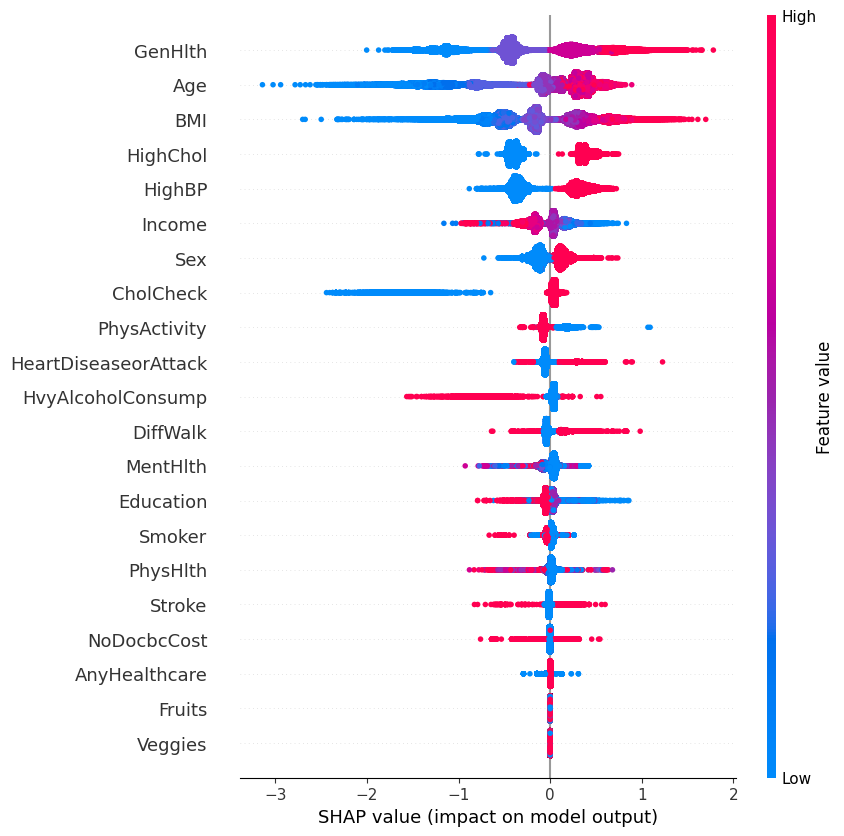

In [11]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(data)

shap.plots.beeswarm(shap_values, max_display=30)

---

In [24]:
class VirtualDataset:
    def __init__(self, model_class, model_params, eval_metric, n_iter=5,):
        self._Model = model_class
        self._params = model_params
        self._metric = eval_metric
        self._max_iter = n_iter
        self._sizes = np.logspace(-2, -1e-5, self._max_iter)

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        self._X_train = X_train
        self._X_test = X_test
        self._y_train = y_train
        self._y_test = y_test

        scores = []
        for i, size in enumerate(self._sizes):
            X, _, y, _ = train_test_split(self._X_train, self._y_train, test_size=1-size, stratify=self._y_train)
            model = self._Model(**self._params)
            model.fit(X, y)
            score = self._metric(model.predict(self._X_test), self._y_test)
            scores.append(score)
        return {'DatasetSize': (self._sizes * len(X)).astype(int), 'Score': scores}

In [25]:
vds = VirtualDataset(CatBoostClassifier, model_params | {'silent': True}, f1_score, n_iter=10)
vds_res = vds.fit(data.to_numpy(), target.to_numpy())

<Axes: xlabel='DatasetSize'>

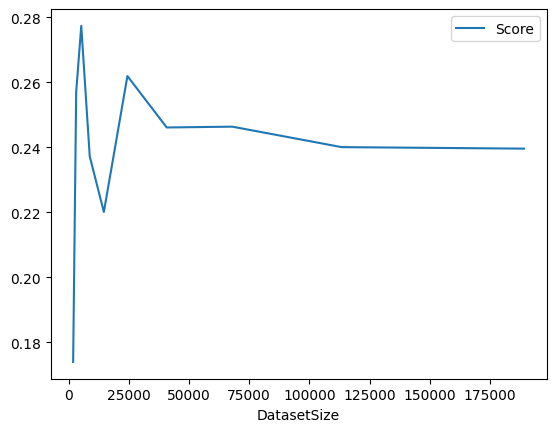

In [26]:
pd.DataFrame(vds_res).plot(x='DatasetSize', y='Score')

---